In [3]:
!pip -q install pandas numpy scikit-learn rdkit chembl_webresource_client tqdm matplotlib

In [21]:
import math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from chembl_webresource_client.new_client import new_client

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt


def smiles_to_morgan_fp(smiles, n_bits=2048, radius=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


def to_pIC50(value, units):

    if value is None or units is None:
        return None
    try:
        v = float(value)
    except:
        return None
    units = units.strip()
    if units == "nM":
        molar = v * 1e-9
    elif units in ["uM", "µM"]:
        molar = v * 1e-6
    elif units == "mM":
        molar = v * 1e-3
    elif units == "M":
        molar = v
    else:
        return None

    if molar <= 0:
        return None
    return -math.log10(molar)


In [19]:
import math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from chembl_webresource_client.new_client import new_client

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt


def smiles_to_morgan_fp(smiles, n_bits=2048, radius=2):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


def to_pIC50(value, units):

    if value is None or units is None:
        return None
    try:
        v = float(value)
    except:
        return None

    units = units.strip()
    if units == "nM":
        molar = v * 1e-9
    elif units in ["uM", "µM"]:
        molar = v * 1e-6
    elif units == "mM":
        molar = v * 1e-3
    elif units == "M":
        molar = v
    else:
        return None

    if molar <= 0:
        return None
    return -math.log10(molar)


In [20]:
targets = list(new_client.target.search("lysyl oxidase"))

df_t = pd.DataFrame([{
    "chembl_id": t.get("target_chembl_id"),
    "pref_name": t.get("pref_name"),
    "organism": t.get("organism"),
    "target_type": t.get("target_type")
} for t in targets])

df_t_hs = df_t[(df_t["organism"] == "Homo sapiens") & (df_t["target_type"] == "SINGLE PROTEIN")].copy()

if len(df_t_hs) == 0:
    print()
    display(df_t.head(20))
else:
    display(df_t_hs.head(20))


,chembl_id,pref_name,organism,target_type
0,CHEMBL3714029,Lysyl oxidase homolog 2,Homo sapiens,SINGLE PROTEIN
1,CHEMBL4295926,Lysyl oxidase homolog 4,Homo sapiens,SINGLE PROTEIN
4,CHEMBL2249,Protein-lysine 6-oxidase,Homo sapiens,SINGLE PROTEIN
6,CHEMBL4105989,Lysyl oxidase homolog 3,Homo sapiens,SINGLE PROTEIN
8,CHEMBL4523279,Lysyl oxidase homolog 1,Homo sapiens,SINGLE PROTEIN
11,CHEMBL5575,Lysine--tRNA ligase,Homo sapiens,SINGLE PROTEIN
12,CHEMBL5465273,"Procollagen-lysine,2-oxoglutarate 5-dioxygenase 2",Homo sapiens,SINGLE PROTEIN
14,CHEMBL3293,Dual oxidase 2,Homo sapiens,SINGLE PROTEIN
15,CHEMBL4112,Amine oxidase [copper-containing] 2,Homo sapiens,SINGLE PROTEIN
17,CHEMBL1250375,NADPH oxidase 4,Homo sapiens,SINGLE PROTEIN


In [16]:
TARGET_CHEMBL_ID = "CHEMBL3714029"
print("Wybrany target:", TARGET_CHEMBL_ID)


Wybrany target: CHEMBL3714029


In [15]:
activity = new_client.activity

acts = activity.filter(
    target_chembl_id=TARGET_CHEMBL_ID,
    standard_type="IC50",
    standard_relation="="
).only([
    "molecule_chembl_id", "standard_value", "standard_units"
])

acts = list(acts)
print("Liczba rekordów aktywności:", len(acts))

df_a = pd.DataFrame(acts)
df_a["pIC50"] = df_a.apply(lambda r: to_pIC50(r["standard_value"], r["standard_units"]), axis=1)
df_a = df_a.dropna(subset=["pIC50"]).copy()
df_a = df_a.drop_duplicates(subset=["molecule_chembl_id"]).copy()

print("Po czyszczeniu (pIC50 + unikalne cząsteczki):", len(df_a))
df_a.head()


Liczba rekordów aktywności: 666
Po czyszczeniu (pIC50 + unikalne cząsteczki): 380


,molecule_chembl_id,standard_units,standard_value,units,value,pIC50
0,CHEMBL4068784,nM,190.0,uM,0.19,6.721246
1,CHEMBL1618272,nM,83.0,uM,0.083,7.080922
4,CHEMBL4072524,nM,321.0,uM,0.321,6.493495
5,CHEMBL4099444,nM,203.0,uM,0.203,6.692504
6,CHEMBL3467241,nM,309.0,uM,0.309,6.510042


In [11]:
molecule = new_client.molecule
ids = df_a["molecule_chembl_id"].tolist()

def fetch_molecules_in_chunks(id_list, chunk_size=200):
    rows = []
    for i in tqdm(range(0, len(id_list), chunk_size)):
        chunk = id_list[i:i+chunk_size]
        mols = molecule.filter(molecule_chembl_id__in=chunk).only(["molecule_chembl_id", "molecule_structures"])
        for m in mols:
            ms = m.get("molecule_structures") or {}
            smi = ms.get("canonical_smiles")
            if smi:
                rows.append({"molecule_chembl_id": m["molecule_chembl_id"], "smiles": smi})
    return pd.DataFrame(rows)

df_s = fetch_molecules_in_chunks(ids)
df = df_a.merge(df_s, on="molecule_chembl_id", how="inner").dropna(subset=["smiles"]).copy()

print("Z rekordami SMILES:", len(df))
df.head()


  0%|          | 0/2 [00:00<?, ?it/s]

Z rekordami SMILES: 380


,molecule_chembl_id,standard_units,standard_value,units,value,pIC50,smiles
0,CHEMBL4068784,nM,190.0,uM,0.19,6.721246,NCc1ccnc(Cl)c1
1,CHEMBL1618272,nM,83.0,uM,0.083,7.080922,N#CCCN
2,CHEMBL4072524,nM,321.0,uM,0.321,6.493495,NCc1ccnc(-c2cccnc2)c1
3,CHEMBL4099444,nM,203.0,uM,0.203,6.692504,NCc1ccnc(-n2ccnc2)c1
4,CHEMBL3467241,nM,309.0,uM,0.309,6.510042,NCc1ccnc(Oc2ccccc2)c1


  0%|          | 0/380 [00:00<?, ?it/s]

[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerator
[19:02:35] DEPRECATION WARNING: please use MorganGenerat

Macierz cech X: (380, 2048)   wektor y: (380,)
MAE = 0.385 pIC50
R²  = 0.446


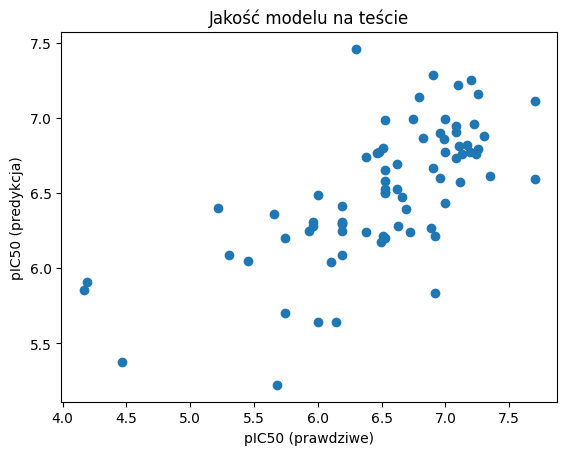

In [12]:
fps = []
ys = []

for smi, y in tqdm(zip(df["smiles"], df["pIC50"]), total=len(df)):
    fp = smiles_to_morgan_fp(smi)
    if fp is not None:
        fps.append(fp)
        ys.append(y)

X = np.vstack(fps)
y = np.array(ys)

print("Macierz cech X:", X.shape, "  wektor y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"MAE = {mae:.3f} pIC50")
print(f"R²  = {r2:.3f}")

plt.figure()
plt.scatter(y_test, pred)
plt.xlabel("pIC50 (prawdziwe)")
plt.ylabel("pIC50 (predykcja)")
plt.title("Jakość modelu na teście")
plt.show()


In [14]:
my_smiles = [
    "CCO",
    "CC(=O)O",
]

rows = []
for smi in my_smiles:
    fp = smiles_to_morgan_fp(smi)
    if fp is None:
        rows.append({"smiles": smi, "pred_pIC50": None, "note": "niepoprawny SMILES"})
    else:
        rows.append({"smiles": smi, "pred_pIC50": float(model.predict(fp.reshape(1, -1))[0]), "note": ""})

pd.DataFrame(rows).sort_values("pred_pIC50", ascending=False)


[19:05:04] DEPRECATION WARNING: please use MorganGenerator
[19:05:04] DEPRECATION WARNING: please use MorganGenerator


,smiles,pred_pIC50,note
0,CCO,6.352549,
1,CC(=O)O,5.988443,
